# Deep Neural Network for Image Classification: Application

We will build a cat/not-a-cat classifier, using the functions from the previous assignment to build a deep network.

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- [4 - Two-layer Neural Network](#4)
    - [Step 1 - two_layer_model](#step-1)
    - [4.1 - Train the model](#4-1)
- [5 - L-layer Neural Network](#5)
    - [Step 2 - L_layer_model](#step-2)
    - [5.1 - Train the model](#5-1)
- [6 - Results Analysis](#6)
- [7 - Test with your own image (optional/ungraded exercise)](#7)

<a name='1'></a>
## 1 - Packages

In [4]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
zip_path = '/content/' + 'datasets.zip'
extract_path = '/content/'

import zipfile

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


<a name='2'></a>
## 2 - Load and Process the Dataset

We'll be using the same "Cat vs non-Cat" dataset as in my logistic regression cat classifier project. The model built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, this new model will perform even better!

**Problem Statement**: A dataset ("data.h5") containing:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).


In [5]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


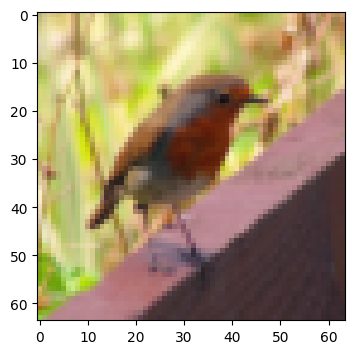

In [6]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [7]:
# Explore the dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [8]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Let's build a deep neural network to distinguish cat images from non-cat images.

We're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, we'll compare the performance of these models, and try out some different values for $L$.

Let's look at the two architectures:

<u><b>Detailed Architecture of 2-layer neural network.</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias).
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<u><b>Detailed Architecture of L-layer neural network</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop)
3. Use trained parameters to predict labels

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='step-1'></a>
### Step 1 - two_layer_model

Let's use the helper functions we have implemented in the previous part to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*.

In [9]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [10]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations

    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """

    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters dictionary
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        # Compute cost
        cost = compute_cost(A2, Y)

        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation.
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        # YOUR CODE ENDS HERE

        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

<a name='4-1'></a>
### 4.1 - Train the model

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.433916315122575
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.17080762978096659
Cost after iteration 1700: 0.11306524562164712
Cost after iteration 1800: 0.09629426845937149
Cost after iteration 1900: 0.08342617959726863
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.0663074813226

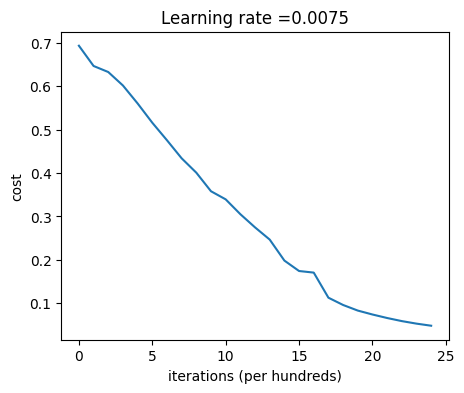

In [11]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

We trained the model so now, let's use the trained parameters to classify images from the dataset.

In [12]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [13]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


Our 2-layer neural network has better performance (72%) than the logistic regression implementation (70%). Let's see if wecan do even better with an $L$-layer model.

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='step-2'></a>
### Step 2 - L_layer_model

Let's use the helper functions we implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*.

In [14]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [15]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost

    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)


    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # Compute cost.
        cost = compute_cost(AL, Y)

        # YOUR CODE ENDS HERE

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

<a name='5-1'></a>
### 5.1 - Train the model

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network.

- The cost should decrease on every iteration.

- It may take up to 5 minutes to run 2500 iterations.

In [16]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366112
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.11382060668633713
Cost after iteration 2100: 0.10783928

In [17]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [18]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


It seems that our 4-layer neural network has better performance (80%) than our 2-layer neural network (72%) on the same test set.

This is a pretty good performance for this task.

In the next work, I'll try to obtain even higher accuracy by systematically searching for better hyperparameters: learning_rate, layers_dims, or num_iterations, for example.  

<a name='6'></a>
##  6 - Results Analysis

First, take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images.

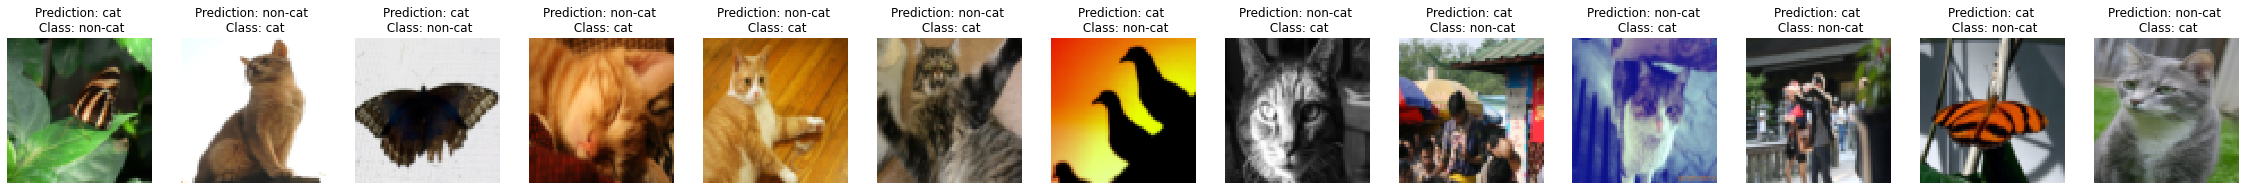

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:**
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image)